In [249]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics

In [250]:
np.random.seed(0)

In [251]:
loaded_data = pd.read_csv("historic_trends_2010_2020.csv")
loaded_data.reset_index(inplace=True)

In [252]:
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20090 entries, 0 to 20089
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         20090 non-null  int64 
 1   date          20090 non-null  object
 2   Donald Trump  20090 non-null  int64 
 3   Putin         20090 non-null  int64 
 4   MeToo         20090 non-null  int64 
 5   Bitcoin       20090 non-null  int64 
 6   ISIS          20090 non-null  int64 
 7   country       20090 non-null  object
dtypes: int64(6), object(2)
memory usage: 1.2+ MB


In [253]:
# Select columns
loaded_data = loaded_data[['date', 'MeToo', 'country']]

In [254]:
meUS = loaded_data[loaded_data['country'] == 'United States']
meGB = loaded_data[loaded_data['country'] == 'United Kingdom']
meDE = loaded_data[loaded_data['country'] == 'Germany']
meCA = loaded_data[loaded_data['country'] == 'Canada']
meNO = loaded_data[loaded_data['country'] == 'Norway']

In [255]:
meUS = meUS.drop(columns=['country', "date"])
meGB = meGB.drop(columns=['country', "date"])
meDE = meDE.drop(columns=['country', "date"])
meCA = meCA.drop(columns=['country', "date"])
meNO = meNO.drop(columns=['country', "date"])

In [256]:
meUS = meUS.rename(columns={"MeToo": "MeToo_US"})
meGB = meGB.rename(columns={"MeToo": "MeToo_GB"})
meDE = meDE.rename(columns={"MeToo": "MeToo_DE"})
meCA = meCA.rename(columns={"MeToo": "MeToo_CA"})
meNO = meNO.rename(columns={"MeToo": "MeToo_NO"})

In [257]:
meUS.reset_index(inplace=True)
meGB.reset_index(inplace=True)
meDE.reset_index(inplace=True)
meCA.reset_index(inplace=True)
meNO.reset_index(inplace=True)

In [258]:
meDE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   index     4018 non-null   int64
 1   MeToo_DE  4018 non-null   int64
dtypes: int64(2)
memory usage: 62.9 KB


In [259]:
newDF = pd.DataFrame()
newDF["US"] = meUS["MeToo_US"]
newDF["GB"] = meGB["MeToo_GB"]
newDF["DE"] = meDE["MeToo_DE"]
newDF["CA"] = meCA["MeToo_CA"]
newDF["NO"] = meNO["MeToo_NO"]

In [260]:
newDF.to_csv("MeToo_by_country.csv")

<AxesSubplot:>

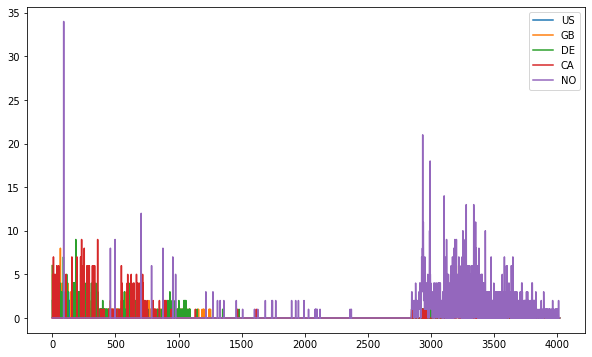

In [261]:
newDF.plot(figsize=(10, 6))

In [262]:
# Normalize: 0-100 to 0-1
newDF = newDF / 100

<AxesSubplot:>

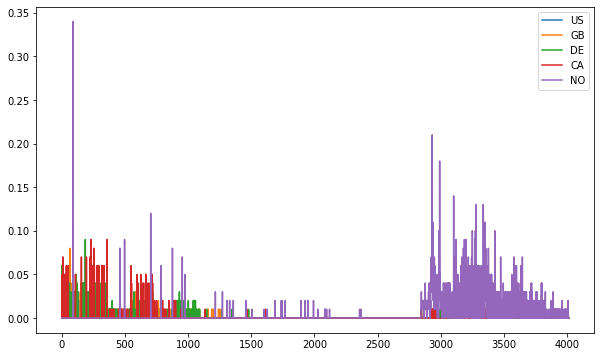

In [263]:
newDF.plot(figsize=(10, 6))

In [264]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series

In [265]:
newDF = scaler.fit_transform(newDF)

In [266]:
# (4018, 5, 1) to (5, 4018, 1)
newDF = np.transpose(newDF, axes=(1, 0, 2))

In [267]:
newDF[0, :, 0].shape

(4018,)

In [268]:
# Compute LCSS between United States (0) and Great Britain (1)
US_IDX = 0
GB_IDX = 1
DE_IDX = 2
CA_IDX = 3
NO_IDX = 4

# Exract 1st YEAR
newDF = newDF[:, :100, :]

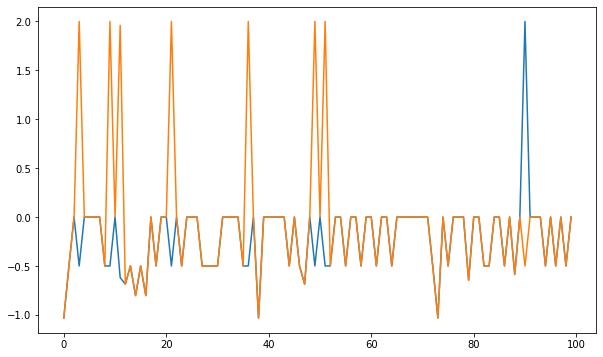

In [279]:
plt.figure(figsize=(10, 6))
plt.plot(newDF[NO_IDX, :, 0], label="Norway")
plt.plot(newDF[CA_IDX, :, 0], label="Canada")


In [270]:

n_ts, sz, d = 2, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset_scaled = scaler.fit_transform(dataset)

In [271]:
dataset.shape, newDF.shape

((2, 100, 1), (5, 100, 1))

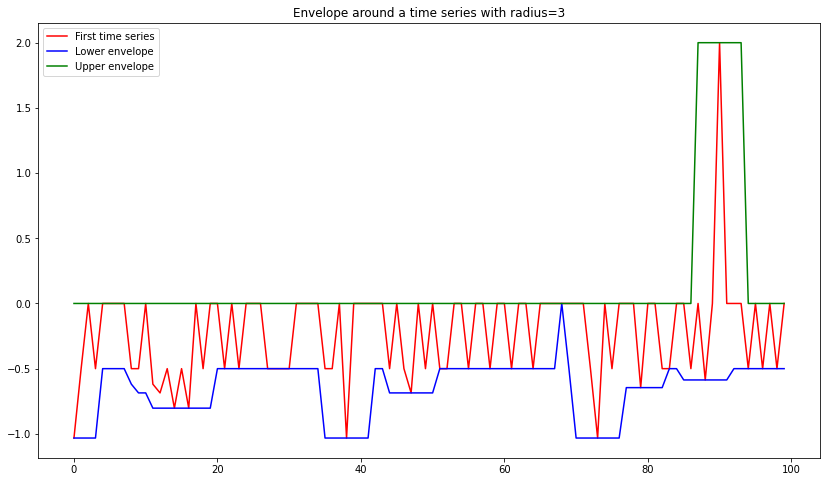

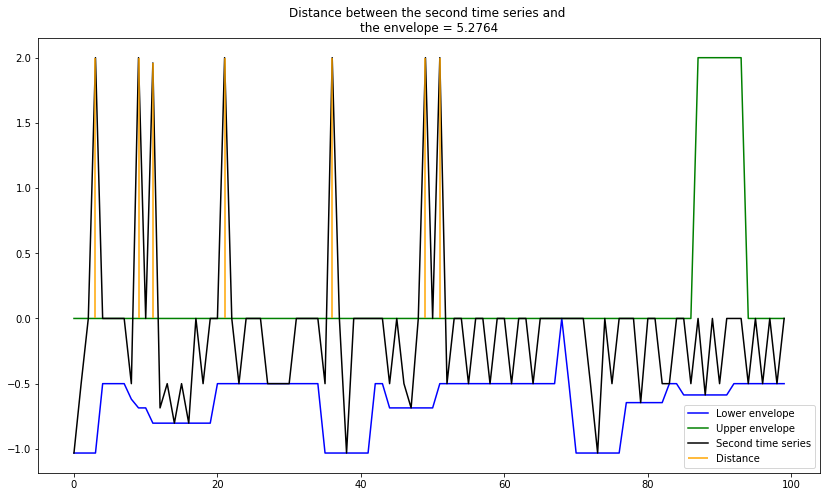

In [273]:
plt.figure(figsize=(14, 8))
envelope_down, envelope_up = metrics.lb_envelope(newDF[NO_IDX], radius=3)
plt.plot(newDF[NO_IDX, :, 0], "r-", label='First time series')
plt.plot(envelope_down[:, 0], "b-", label='Lower envelope')
plt.plot(envelope_up[:, 0], "g-", label='Upper envelope')
plt.legend()
plt.title('Envelope around a time series with radius=3')

plt.figure(figsize=(14, 8))
plt.plot(envelope_down[:, 0], "b-", label='Lower envelope')
plt.plot(envelope_up[:, 0], "g-", label='Upper envelope')
plt.plot(newDF[CA_IDX, :, 0], "k-", label='Second time series')
plt.vlines(np.arange(len(newDF[0, :, 0])), newDF[CA_IDX, :, 0], np.clip(
    newDF[CA_IDX, :, 0], envelope_down[:, 0], envelope_up[:, 0]),
           label='Distance', color='orange')
plt.legend()
lb_k_sim = metrics.lb_keogh(newDF[CA_IDX],
                            envelope_candidate=(envelope_down, envelope_up))
plt.title('Distance between the second time series and \n'
          'the envelope = {:.4f}'.format(lb_k_sim))

plt.show()

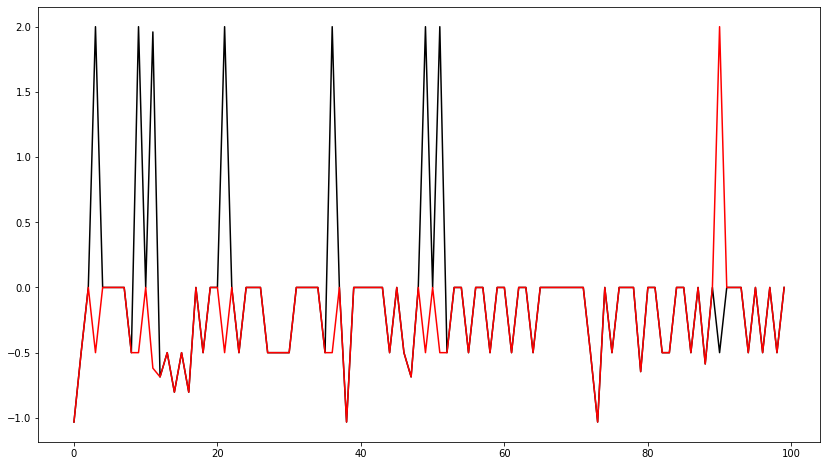

In [275]:
plt.figure(figsize=(14, 8))
plt.plot(newDF[CA_IDX, :, 0], "k-", label='Canada')
plt.plot(newDF[NO_IDX, :, 0], "r-", label='Norway')